In [9]:
def return_parameters(parameters_file : str):
    with open(parameters_file, 'r') as f:
        f.readline()
        sizeof_float = (int)(f.readline())
        f.readline()
        TIME_dt_DTS = f.readline().split(' ')
        TIME = (int)(TIME_dt_DTS[0])
        dt = (float)(TIME_dt_DTS[1])
        DTS = (int)(TIME_dt_DTS[2])
        f.readline()
        SIZE = f.readline().split(' ')
        SIZE_X = (int)(SIZE[0])
        SIZE_Y = (int)(SIZE[1])
        return sizeof_float, TIME, dt, DTS, SIZE_X, SIZE_Y

In [3]:
import os
import sys
import numpy as np

def set_field_frame(t : int, field, field_to_read : str, sizeof_float : int, SIZE_X : int, SIZE_Y : int):
    dtype = np.float32
    
    with open(field_to_read, 'br') as f:
        
        f.seek((t*SIZE_X*SIZE_Y)*sizeof_float, os.SEEK_SET)

        temp = np.fromfile(f, dtype=dtype, count=SIZE_X*SIZE_Y)

        np.copyto(field, temp.reshape(SIZE_Y, SIZE_X))

In [4]:
import matplotlib.pyplot as plt


def set_imshow(subplot, Field: list, cmap_: str, v : tuple, SIZE_X : int, SIZE_Y : int):
    return subplot.imshow(
        Field[:][:],
        cmap = plt.get_cmap(cmap_),
        interpolation="gaussian",
        animated=True,
        origin='lower',
        extent=(0,SIZE_X,0,SIZE_Y),
        vmin=v[0], vmax=v[1],
    )


In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np


def set_colorbar(mappable):
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    cbar = fig.colorbar(mappable,
                       orientation="vertical",
                       cax=cax)
    plt.sca(last_axes)
    return cbar


In [6]:
import matplotlib.pyplot as plt
import numpy as np


def set_whole_ax(axes, cbars : list, ddata_name : list, ddata_enum : dict, SIZE_X, SIZE_Y,
                 current_shape_is_shown = False):
    
    ax = axes[ ddata_name[ddata_enum['axes_position']] ]

    ax.set_title( ddata_name[ ddata_enum['axes_name'] ], fontsize=20)
    ax.set_xlabel( ddata_name[ ddata_enum['xlabel'] ], fontsize=15 )
    ax.set_ylabel( ddata_name[ ddata_enum['ylabel'] ], fontsize=15 )

    im_ = set_imshow(ax,
        ddata_name[ddata_enum['frame_data']],
        ddata_name[ddata_enum['colormap']],
        ddata_name[ddata_enum['vmin_vmax']],
        SIZE_X, SIZE_Y)
        
    cbars.append(set_colorbar(im_))

In [7]:
def clear_whole_figure(axes, cbars, nrows, ncols):
    for i in range(nrows):
        for j in range(ncols):
            axes[i,j].cla()
    
    for i in range(len(cbars)):
        cbars[i].remove()

KeyboardInterrupt: 

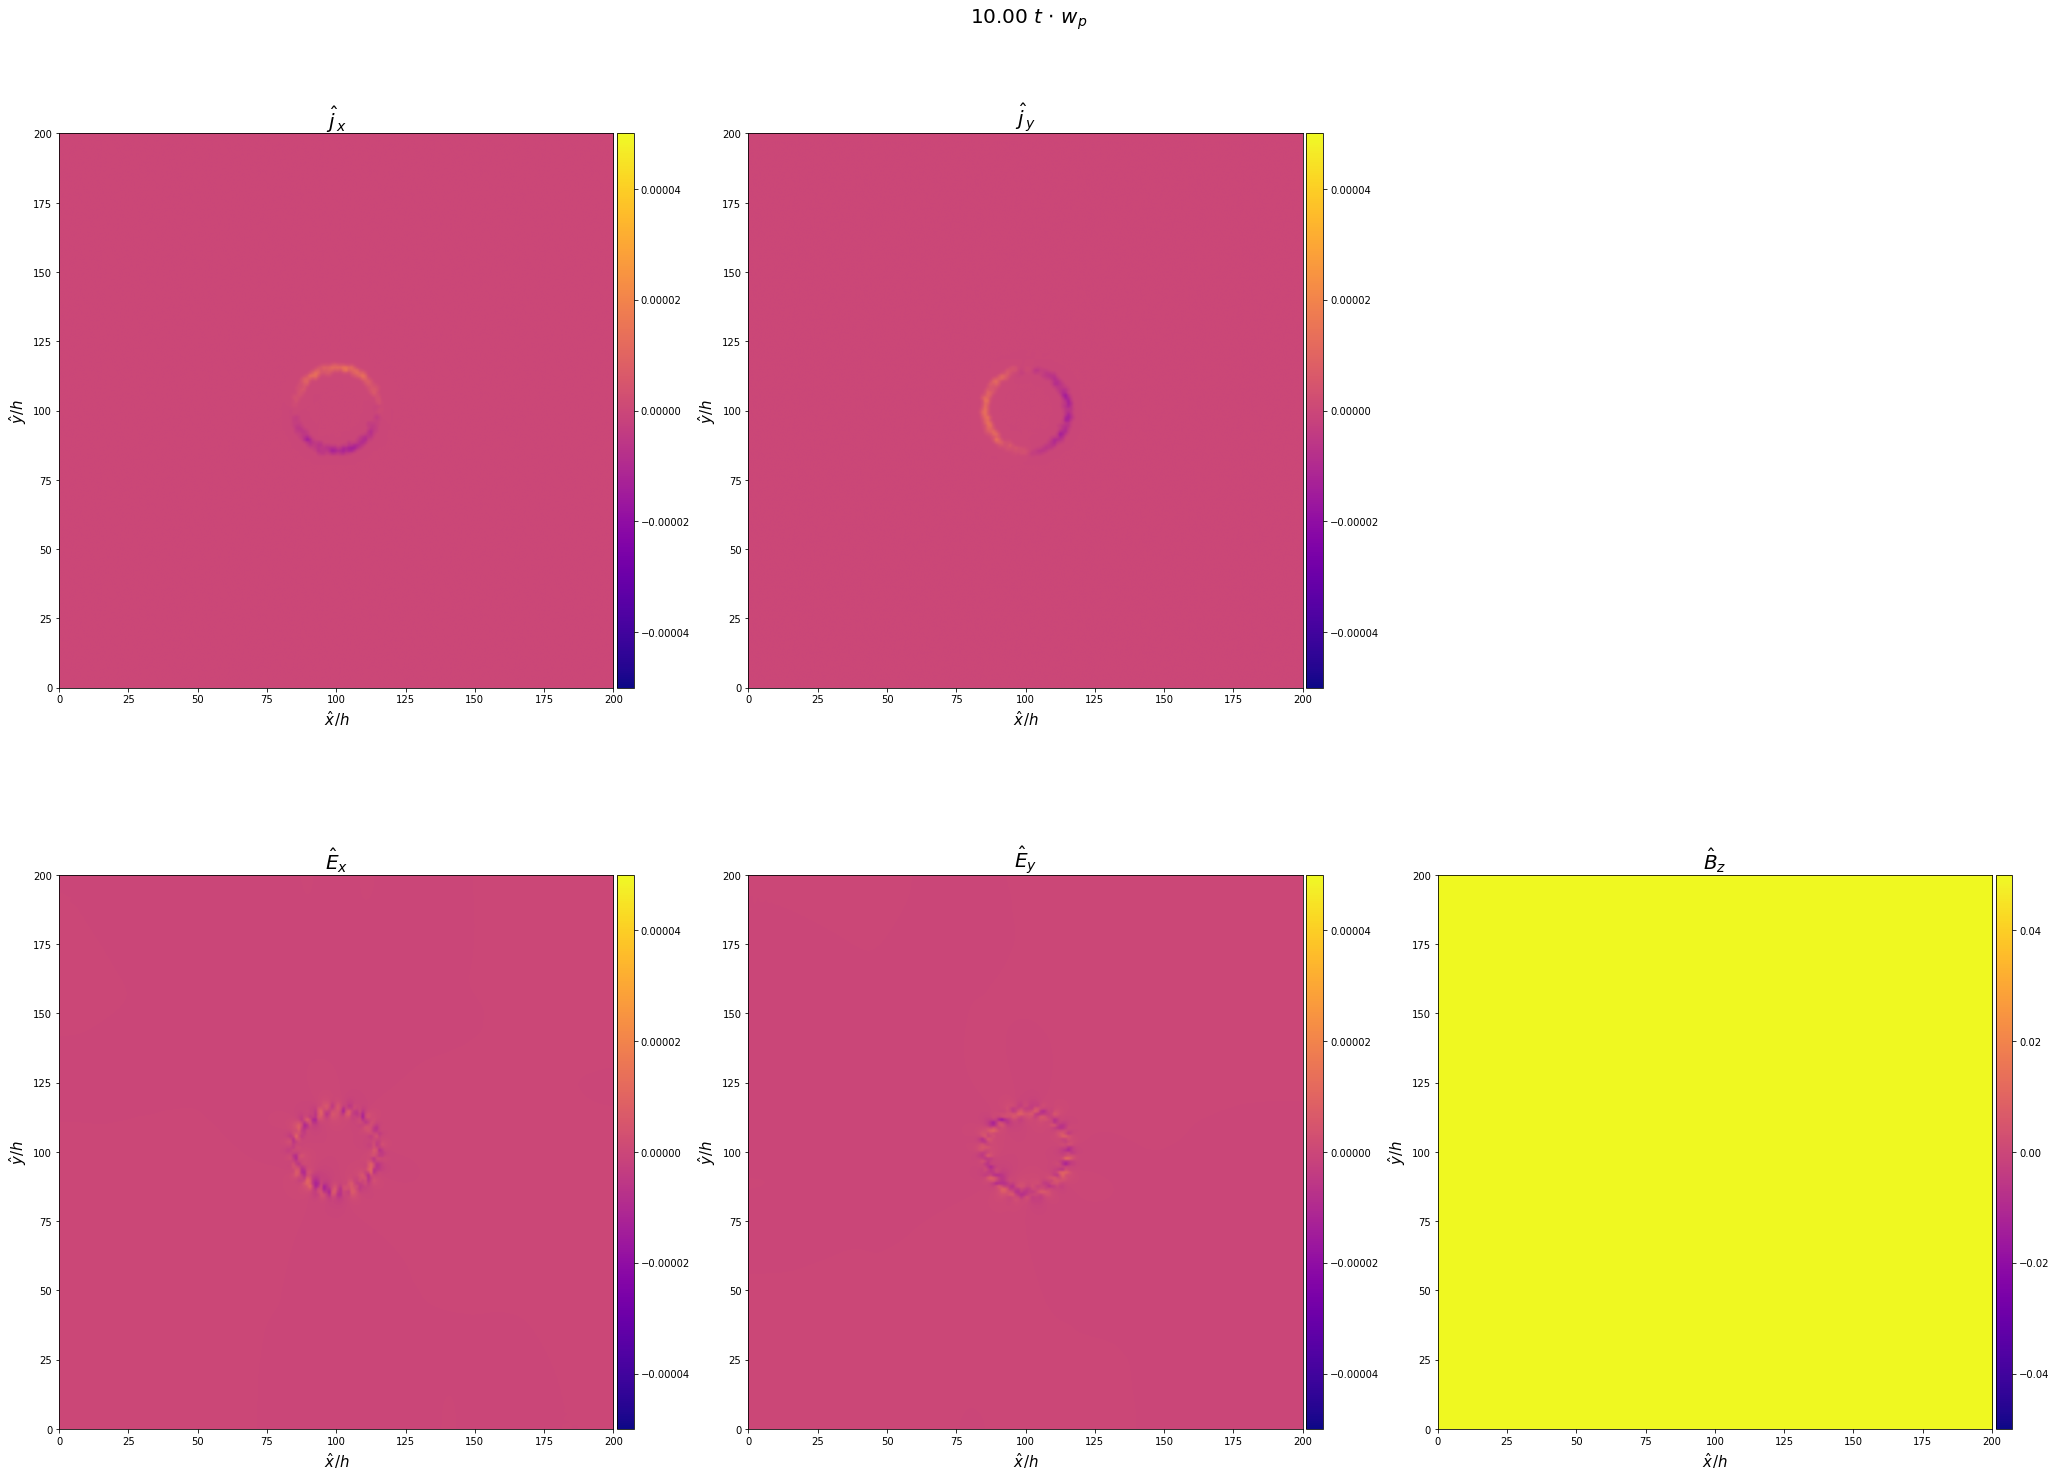

In [10]:
parameters_file = "parameters.txt"
sizeof_float, TIME, dt, DTS, SIZE_X, SIZE_Y = return_parameters(parameters_file)

ddata = {
    
    #'name': ["file.bin", [frame_data], (axes_position), "axes_name", "xlabel", "ylabel" (vmin, vmax), "colormap"]
    'jx': [ "jx.bin", np.zeros((SIZE_Y, SIZE_X)), (0,0), "$\hatj_x$", "$\hatx/h$", "$\haty/h$", (-5e-5, 5e-5), "plasma" ],
    'jy': [ "jy.bin", np.zeros((SIZE_Y, SIZE_X)), (0,1), "$\hatj_y$", "$\hatx/h$", "$\haty/h$", (-5e-5, 5e-5), "plasma" ], 
    'Ex': [ "Ex.bin", np.zeros((SIZE_Y, SIZE_X)), (1,0), "$\hatE_x$", "$\hatx/h$", "$\haty/h$", (-5e-5, 5e-5), "plasma" ],
    'Ey': [ "Ey.bin", np.zeros((SIZE_Y, SIZE_X)), (1,1), "$\hatE_y$", "$\hatx/h$", "$\haty/h$", (-5e-5, 5e-5), "plasma" ],
    'Bz': [ "Bz.bin", np.zeros((SIZE_Y, SIZE_X)), (1,2), "$\hatB_z$", "$\hatx/h$", "$\haty/h$", (-5e-2, 5e-2), "plasma"],  
    'off_ni': [ "../../Ions/density/density.bin", [], (0,2), "$\hatn_e$", "$\hatx/h$", "$\haty/h$", (0, 5), "Greys"], 

}

ddata_enum = {
    
    'file_to_read':     0,
    'frame_data':       1,
    'axes_position':    2,
    'axes_name':        3,
    'xlabel':           4,
    'ylabel':           5,
    'vmin_vmax':        6,
    'colormap':         7,

}

nrows = 2
ncols = 3


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(35,25))

'''
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
proc_num = comm.Get_size()

comm.Barrier()
'''

for t in range(0, int(TIME/DTS)):
    imshows = []
    cbars = []
    
    for name in ddata.keys():
        if (name[:3] != 'off'):
            set_field_frame(t, ddata[name][ddata_enum['frame_data']],
                               ddata[name][ddata_enum['file_to_read']],
                               sizeof_float, SIZE_X, SIZE_Y)
            
        else:
            continue
    

    for name in ddata.keys():
        if (name[:3] != 'off'):
            set_whole_ax(axes, cbars, ddata[name], ddata_enum, SIZE_X, SIZE_Y)
        
        else:
            axes[ ddata[name][ddata_enum['axes_position']] ].axis("off")
    
    axes[0,1].text(0.4, 1.2, "%.2f $t\ {\cdot}\ w_p$" %(DTS*t*dt), transform=axes[0,1].transAxes, fontsize=20)

    name = str(t).zfill(len(str(int(TIME/DTS)-1)))
    fig.savefig("animation/" + name + ".png")
    
    clear_whole_figure(axes, cbars, nrows, ncols)

#import os 

#os.system("cd ./animation/ && (ffmpeg -f image2 %03d.png -r 15 ../../2d_fields.mp4)")


In [ ]:
sys.float_info